<center> <h1> EMD para la caracterización de defectos de vía </center></h1>

### Introducción
    
En el año 1998 N.E.Huang fue pionero en el desarrollo de una herramienta empírica para el análisis de series temporales no lineales y no estacionarias denominada comúnmente como Empyrical Mode Decomposition, EMD por sus siglas en inglés. En caso de que esta técnica se combine con un analisis espectral mediante la transformada de Hilbert, se  denomina Hilbert-Huang Transform (HHT).
    
Ahora bien ¿que significa que una señal sea no lineal y no estacionaria?
* De forma conceptual, se dice que una señal es **no estacionaria** cuando sus propiedades estadisticas varian con el tiempo. Siendo más estrictos se dice que una serie de tiempo es estacionaria de orden dos si su media y varianza son constantes. 
* Una serie es **no lineal** cuando no puede ser representada como una combinación lineal de series independientes ("estrictamente aleatorias")

El algoritmo que sigue esta herramienta se denomina *sifting* y puede resumirse, a grandes rasgos, en los siguientes pasos:
1. Identificación de los extremos de la función (máximos y mínimos)
2. Interpolación de los puntos máximos y mínimos hallados previamente para obtener una evolvente. Lo más común es utilizar splines cúbicas por ser suaves y diferenciables aunque puede traer algunos problemas.
3. Obtención de la media entre las dos evolventes.
4. La diferencia entre la señal y la línea media, da lugar a una función denominada IMF o Intrinsec Mode Function (si cumple las condiciones que un IMF tiene que cumplir).
5. El proceso se repite hasta alcanzar el criterio de parada.

<div>
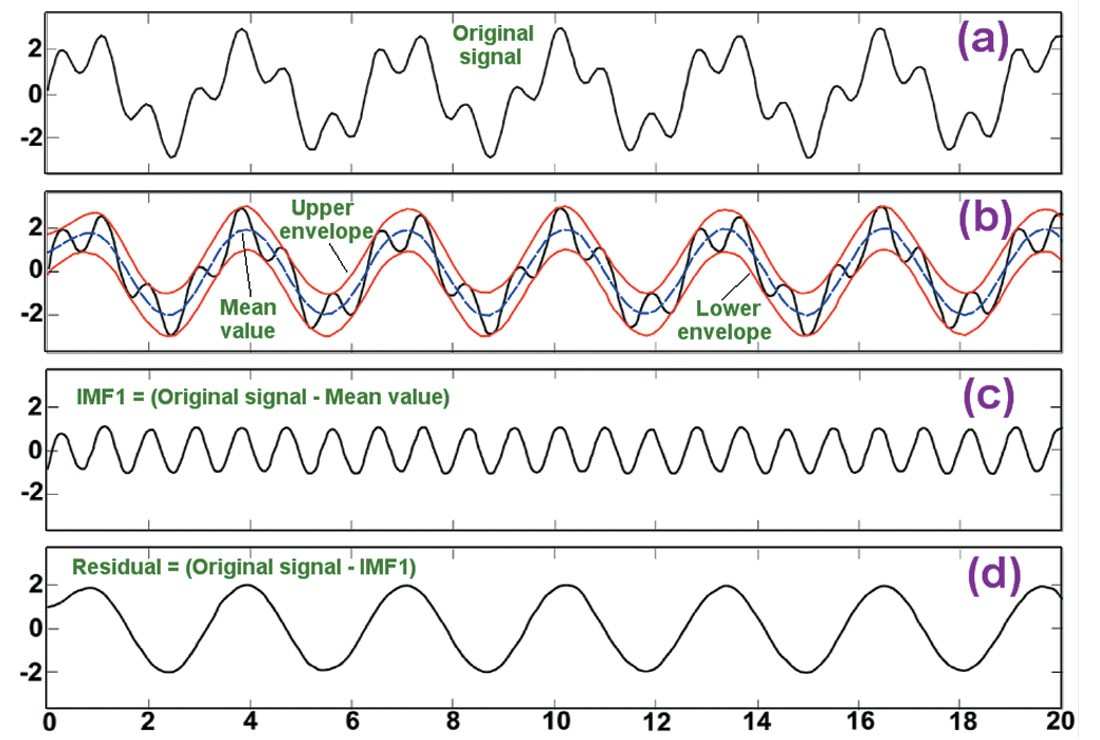
</div>

### Condiciones que un IMF debe cumplir
1. Un IMF sólo tiene un entremo entre dos cruces por cero. Es decir que el número de máximos respecto al de mínimos puede diferir a lo sumo por uno. 
2. El valor medio de un IMF es cero.

Esta segunda condición significa que los IMF son estacionarios (débilmente estacionarios), simplificando el análisis. Sin embargo, los IMF pueden tener amplitud modulada y frecuencia variable en el tiempo.
Cabe aclarar que la interpretación de los IMF no es tan transparente y es un desafío combinar varios de ellos para obtener señales físicamente representativas de la realidad. 

### Ventajas de la herramienta
* No se encuentra limitada a series temporales lineales y estacionarias como la gran mayoría de las técnicas de análisis.
* Es data-driven, es decir que su aplicación depende y se ajusta según los datos de la serie. En este sentido, la base con la cual se describe la serie temporal es adaptativa y más eficiente que Fourier o Wavelets.
* Evita la aparición de componentes frecuenciales espurias, en la mayoría de los casos. En este aspecto funciona mucho mejor que la FFT.
* Permite descomponer una señal compleja en varios IMF que son monocomponentes, a los cuales se les puede aplicar la transformada de Hilbert y calcular una frecuencia que sea representativa.

### Desventajas de la herramienta
* Es computacionalmente mas costosa que otras herramientas como la FFT. La cosa se complica para gran cantidad de datos, es decir series temporales largas o de frecuencia de muestreo elevada.
* Los IMF no son fáciles de interpretar en la mayoría de los casos.
* Hay que tener cuidado con el *mode mixing*, es decir oscilaciones que se acoplan en varios IMF en lugar de ser aisladas en uno. Esto lo resuelve generalmente bien el EEMD, una técnica que utiliza las propiedades del ruido blanco aunque es más costosa.
* No se puede asegurar una única descomposición modal puesto que es sensible a ciertas condiciones en el cálculo.


In [1]:
# Import libraries
from PyEMD import EMD, EEMD, Visualisation
import PyEMD
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert, detrend, welch
from statsmodels.tsa.stattools import adfuller

#Matplotlib
%matplotlib inline

#.Find Nearest Fuction
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [2]:
# Define signal
path=r'C:\Users\nahuel.mendez\Downloads\DEF_LM_CSRM26_RET-SUA_0001.csv'
signal= pd.read_csv(path,sep=',',skiprows=7) #Normally skiprows = 7 
signal = pd.DataFrame.to_numpy(signal)
s = signal[:,7]-np.mean(signal[:,7])
t = signal[:,0]
V = signal[:,12]
Lon=signal[:,9]
Lat=signal[:,10]
fs=5000
#d = (13443+np.cumsum(V/(3.6*fs)))/1000-0.070
#d=((14888-np.cumsum(V/(3.6*fs)))/1000)-0.070
d = np.cumsum(V/(3.6*fs))/1000

<ipython-input-3-ff0394af2715>:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


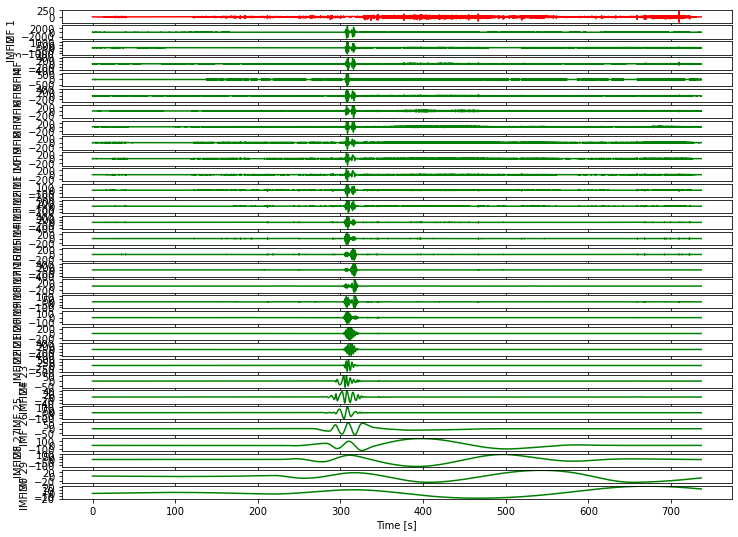

In [3]:
#APlico EMD

emd = EMD(range_thr=20)   #Limites de error para el acelerometro?
emd.emd(s)
IMF, res = emd.get_imfs_and_residue()
N = IMF.shape[0]+1

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(N, 1, 1)
plt.plot(t, s, 'r')

for n in range(N-1):
    plt.subplot(N, 1, n+2)
    plt.plot(t, IMF[n], 'g')
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
#plt.savefig('eemd_example', dpi=120)
plt.show()

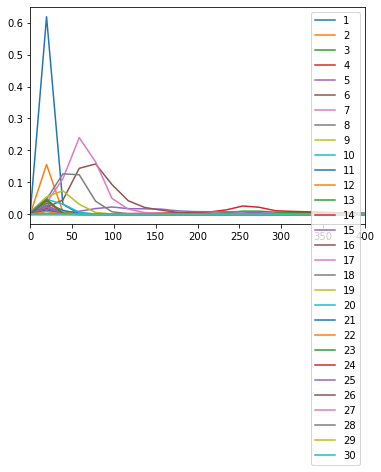

In [4]:
for i in range(0,N-1):
    freqs, psd = welch(IMF[i], fs=fs)
    plt.plot(freqs,psd,label=str(i+1))

plt.rcParams['figure.figsize']=(15,10)    
plt.legend()
plt.xlim(0,400)
plt.show()

In [6]:
#Agrupo los IMF
Primer =3 #Primer IMF
Ultimo = N-1 #Ultimo

for i in range(Primer,Ultimo):
    analytic_signal = hilbert(IMF[i])
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /
                               (2.0*np.pi) * fs)
    if i==Primer:
        Frecuencia = abs(instantaneous_frequency)
        Tiempo = d[1:]
        Energia = amplitude_envelope[1:]
    else:
        Frecuencia = np.concatenate((Frecuencia,abs(instantaneous_frequency)),axis=0)
        Tiempo = np.concatenate((Tiempo,d[1:]),axis=0)
        Energia = np.concatenate((Energia,amplitude_envelope[1:]),axis=0)

RuntimeError: Error in qhull Delaunay triangulation calculation: insufficient memory (exitcode=4); use python verbose option (-v) to see original qhull error.

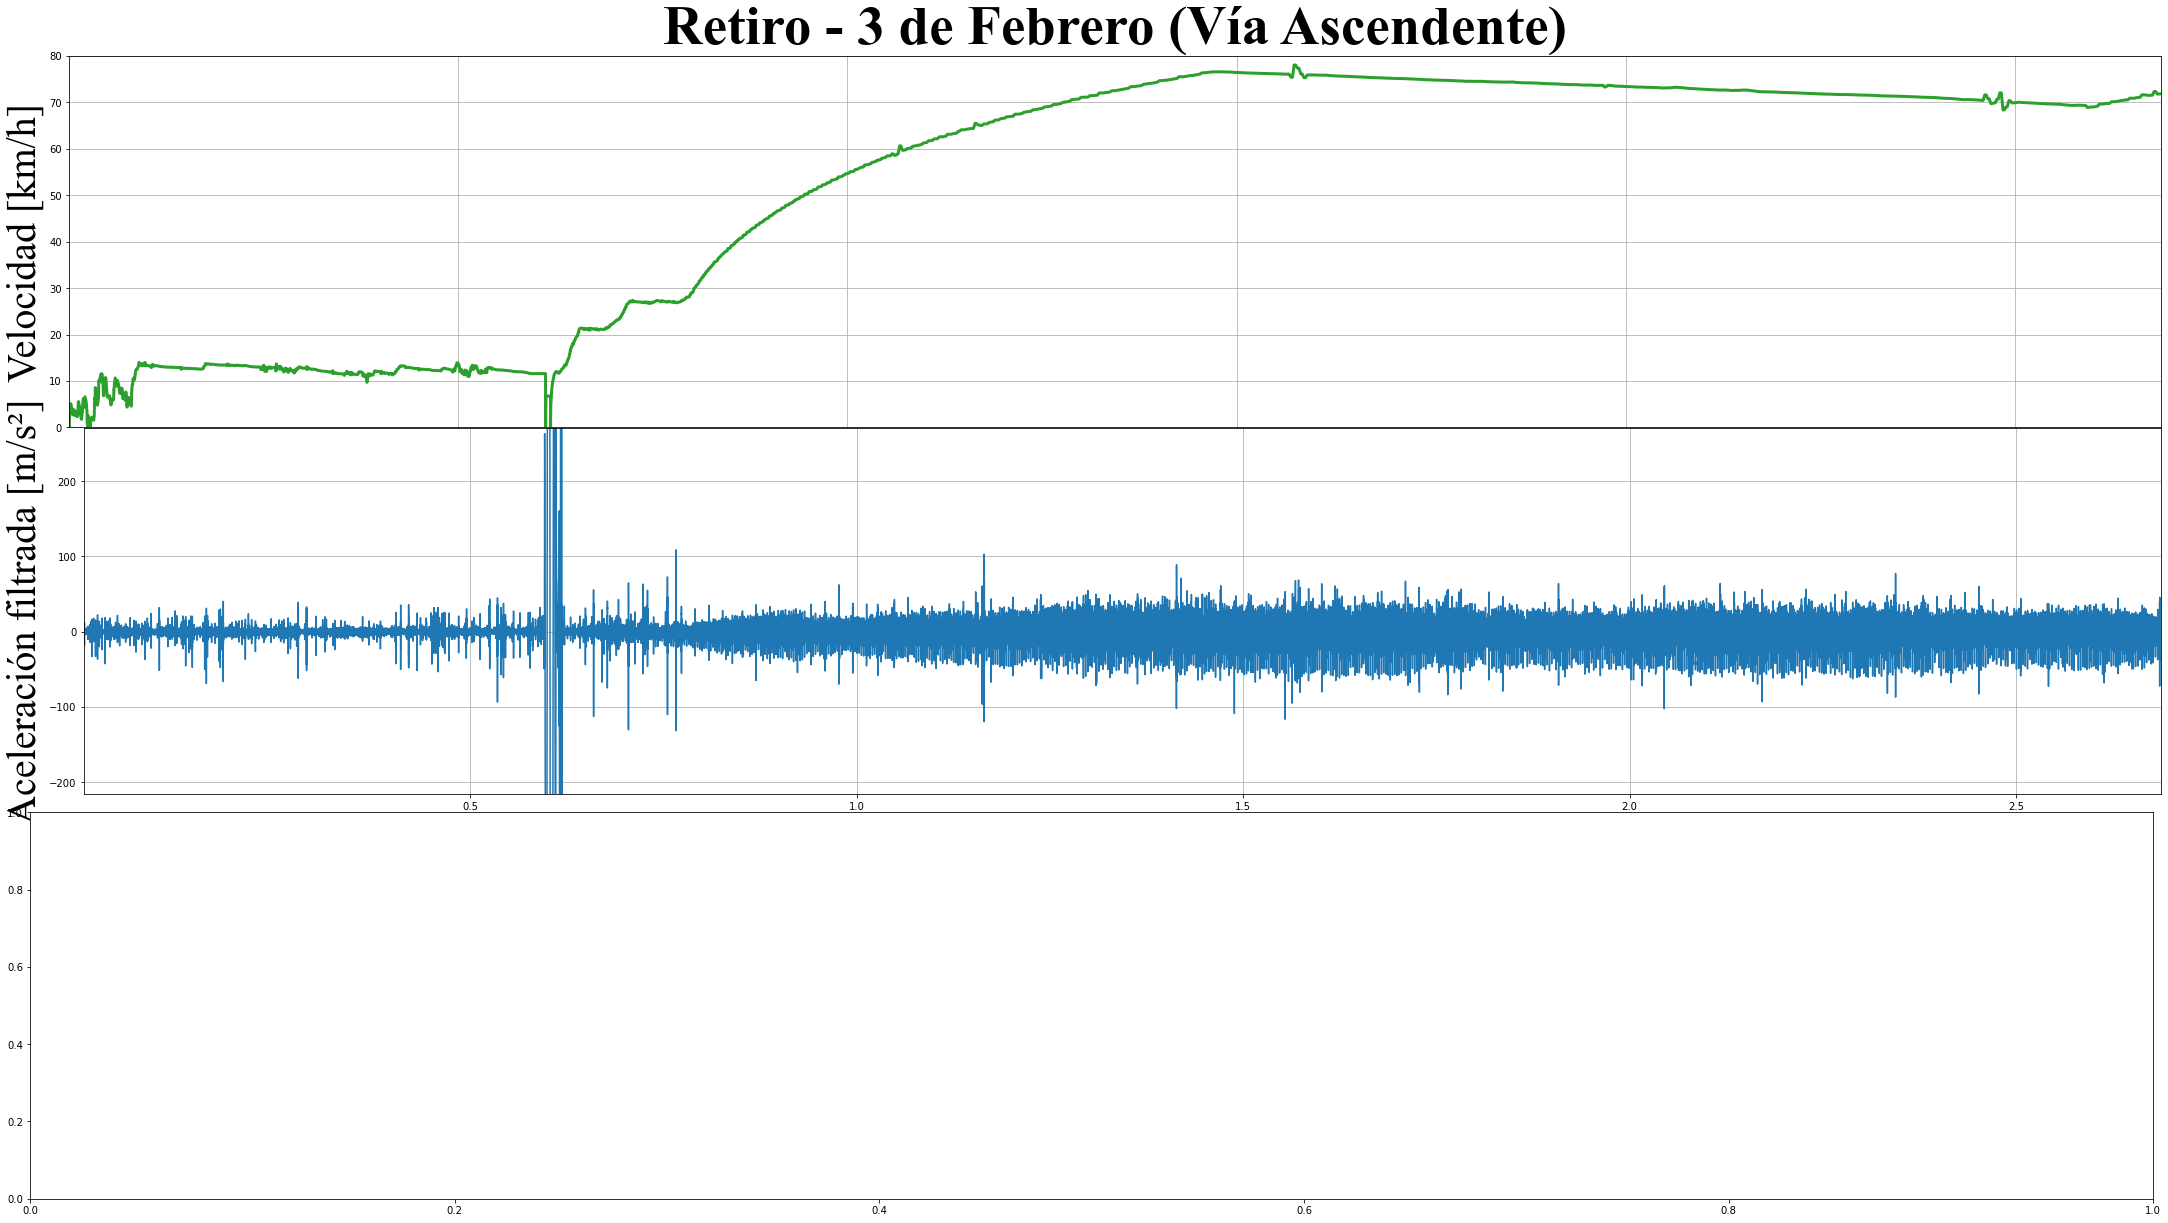

In [10]:
plt.rcParams['figure.figsize']=(60/2,33.75/2)
plt.subplots(nrows=3,ncols=1,sharex=True,constrained_layout=True)
plt.subplot(311)
plt.plot(d,V,'tab:green',linewidth=3)
#plt.vlines(pts,0,80,colors='r',linestyles='dashed')
plt.ylim(0,80)
plt.xlim(d[0],d[-1]/2)
plt.grid(True)
plt.ylabel('Velocidad [km/h]',fontsize=40,fontfamily='Times New Roman')
plt.title("Retiro - 3 de Febrero (Vía Ascendente)",pad=10,fontsize=55,fontweight="bold",fontfamily='Times New Roman')

plt.subplot(312)
plt.plot(d,sum(IMF[3:15]),'tab:blue')
#plt.vlines(pts,min(s)-10,max(s)+10,colors='r',linestyles='dashed')
plt.xlim(d[0],d[-1]/2)
plt.ylim(round(min(s)-10,0),round(max(s)+10,0))
plt.grid(True)
plt.ylabel('Aceleración filtrada [m/s²]',fontsize=40,fontfamily='Times New Roman')
#for i in range(0,len(pts)):
#    plt.text(pts[i]-0.0025, 100, str(i+1), style='italic', bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 5},fontsize=25,c='w')

plt.subplot(313)
plt.tricontourf(Tiempo,Frecuencia,Energia**2,levels=np.linspace(0,1773.872936666073,500),cmap='gnuplot2')
plt.ylim(0,400)
plt.xlim(d[0],d[-1]/2)
plt.xlabel('Progresiva Estimada [km]',fontsize=40,fontfamily='Times New Roman')
plt.ylabel('Frecuencia Instantánea [Hz]', fontsize=40,fontfamily='Times New Roman')
plt.colorbar().set_label(label='Energía [(m/s²)²]', size=28, family='Times New Roman')
plt.xticks(np.arange(d[0],d[-1]/2,0.02))

plt.savefig(r'C:\Users\nahuel.mendez\Downloads\MRS Retiro-3deFebrero1.png',dpi=100)

In [ ]:
plt.plot(d)
plt.rcParams['figure.figsize']=(20,10)

In [5]:
np.savetxt(r'C:\Users\nahuel.mendez\Downloads\IMFs.txt',IMF)

In [ ]:
IMF = np.loadtxt(r'C:\Users\nahuel.mendez\Downloads\IMFs.txt', sep=',')